In [134]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt

# Investigate Gradients
This notebooks gives basic analysis tools for gradients behavior of different activation functions. As dataset fashion_mnist is used. Its a little harder than mnist and therfore justifies two more convolutional layers, which give the gradients more room to explode or vanish.

### Load the dataset.

In [135]:
# TensorFlow has some popular datasets already included. 
# Check out https://www.tensorflow.org/api_docs/python/tf/keras/datasets.
# In this homework we will work with the popular MNIST dataset.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

BATCH=128

### Visualize the dataset.

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
255
0


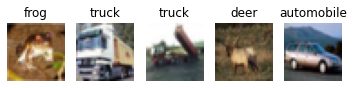

In [136]:
# visualise the dataset, as in the notebooks from courseware

#mapping the numeric labels to their corresponding names
labMap={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
print(np.max(train_images[0]))
print(np.min(train_images[0]))
fig, ax = plt.subplots(1,5)

for i in range(5):

    # Readout an image and the corresponding label.
    img = train_images[i]
    lbl = train_labels[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(labMap[lbl[0]])
    ax[i].axis("off")

### Build the TensorFlow dataset: Input pipeline
Two different training datasets are build. One without data normalization and one with pixels values centered around zero.

In [137]:
def process(dataset,labels):

  #take only a small part of the data
  #dataset=dataset[:int(len(dataset)/5)]

  dataset_images = tf.data.Dataset.from_tensor_slices(dataset)
  
  #normalize the data
  dataset_images=dataset_images.map(lambda x:tf.cast(2*(x/255)-1,tf.float32))

  #the labels are in the wrong shape (x,1), transform them to (x)
  labels=labels.reshape((-1))

  labels = tf.data.Dataset.from_tensor_slices(labels)

  #one hot encode, there are 10 different labels
  labels = labels.map(lambda t : tf.one_hot(t, 10))

  data=tf.data.Dataset.zip((dataset_images, labels))
  
  data=data.shuffle(BATCH)
  data=data.batch(BATCH)
  return data


train_dataset = process(train_images,train_labels)
test_dataset = process(test_images,test_labels)

### Build the model.
A simple CNN Architecture that initializes all convolutional layers with a given activation function. The kerne initializers are default but are given a seed for reproducibility.

In [138]:
 
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self, activation, seed):
        super(Model, self).__init__()
        # Define the layers.
        self.hidden_layers = [
            tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                    activation=activation,
                                    input_shape=(32,32,3),
                                    padding='same',
                                    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)
                                    
                                               ),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                               activation=activation,
                                               padding='same',
                                               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)
                                               ),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                                                activation=activation,
                                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)
                                                ),
            tf.keras.layers.MaxPool2D(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                               activation=activation,
                                               padding='same',
                                               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)

                                                ),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                            activation=activation,
                                            padding='same',
                                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)

                                            ),
            tf.keras.layers.MaxPool2D(),
            
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                                                activation=activation,
                                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)
                                                ),
            tf.keras.layers.MaxPool2D(),

            tf.keras.layers.GlobalAveragePooling2D(),

            tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax,     
                                  kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)
                                )

        ]
    @tf.function
    def call(self, x):
        # Define the forward step.
        for layer in self.hidden_layers:
          x = layer(x)
        return x

In [139]:
#taken from the courseware notebook

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
def plot(train_losses,test_losses,test_accuracies):
  plt.figure()
  x = list(range(len(train_losses)))
  line1, = plt.plot(x, train_losses, label='training')
  line2, = plt.plot(x, test_losses, label='test')
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.figure()
  line1, = plt.plot(test_accuracies)
  plt.xlabel("Training steps")
  plt.ylabel("Accuracy")
  plt.show()

In [140]:
# as in the original notebooks
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss,test_accuracy 

def train_model(model, train_dataset, loss_function, optimizer, epochs):
    train_losses = []
    test_losses=[]
    test_accuracies=[]
    running_average_factor = 0.95
    # We train for num_epochs epochs.
    for epoch in range(num_epochs):
        print('Epoch: __ ' + str(epoch))
        #training
        running_average = 0
        for (input,target) in train_dataset:
            train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
            running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
        train_losses.append(running_average)
        #testing
        test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        if epoch>0 and epoch%10==0:
          plot(train_losses,test_losses,test_accuracies)

        
    plot(train_losses,test_losses,test_accuracies)
    
    return train_losses


### Training
Lets train multiple models with different activations for one epoch.
The random seeds guarantee the same weight initialization for all models.
Change the global seed for a different weight which are still the same for all models.

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10


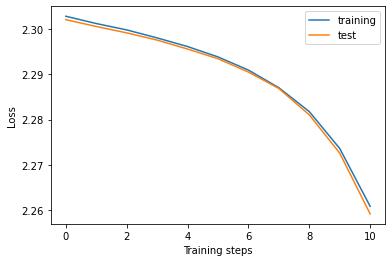

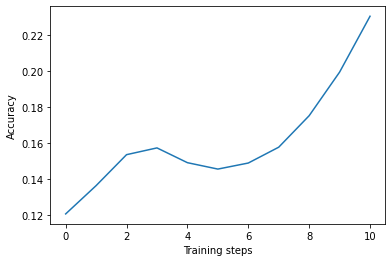

Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20


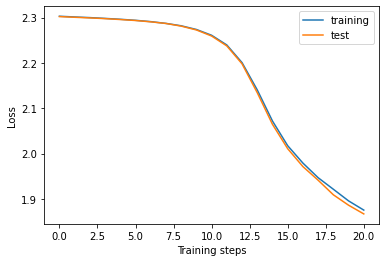

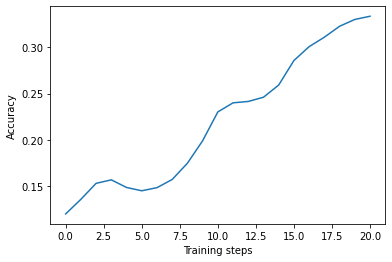

Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24
Epoch: __ 25
Epoch: __ 26
Epoch: __ 27
Epoch: __ 28
Epoch: __ 29
Epoch: __ 30


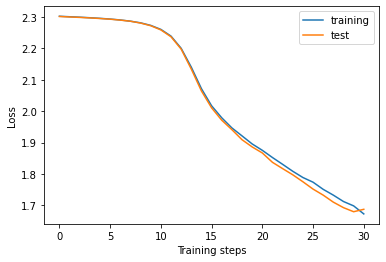

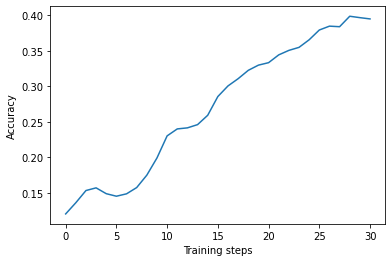

Epoch: __ 31
Epoch: __ 32
Epoch: __ 33
Epoch: __ 34
Epoch: __ 35
Epoch: __ 36
Epoch: __ 37
Epoch: __ 38
Epoch: __ 39
Epoch: __ 40


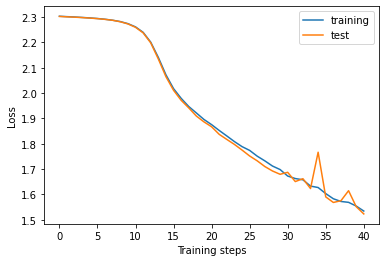

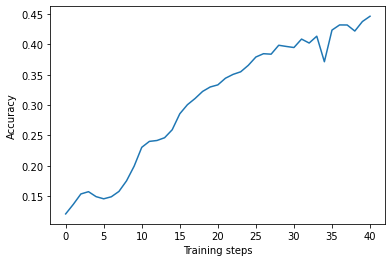

Epoch: __ 41
Epoch: __ 42
Epoch: __ 43
Epoch: __ 44
Epoch: __ 45
Epoch: __ 46
Epoch: __ 47
Epoch: __ 48
Epoch: __ 49


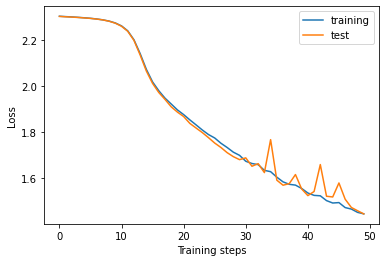

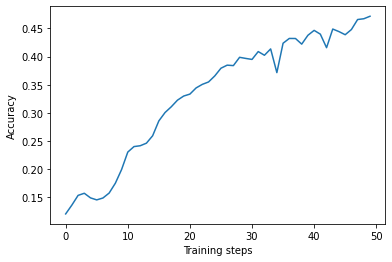

In [141]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 50
learning_rate = 0.001
# reset the global seed after each model initialization to create identical starting weights
# change global seed for different weights
global_seed = 3
seed = 1

# train the models for one epoch
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate)


# again but with centered input data
tf.random.set_seed(global_seed)
model_relu = Model(activation=tf.keras.activations.relu, seed=seed)

train_losses = train_model(model_relu, train_dataset, cross_entropy_loss, optimizer, num_epochs)
